In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from collections import namedtuple, deque
import matplotlib.pyplot as plt
%matplotlib inline



env = UnityEnvironment(file_name=r"H:\Github\udacity_drl_project\Banana_Windows_x86_64\Banana.exe", no_graphics=True)

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


academy_name
brain_names
brains
close
communicator
curriculum
executable_launcher
external_brain_names
get_communicator
global_done
logfile_path
number_brains
number_external_brains
port
proc1
reset
send_academy_parameters
step
wrap_unity_input
Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


In [2]:
env_info = env.reset(train_mode=False)[brain_name]  # reset the environment
state = env_info.vector_observations[0]  # get the current state
score = 0  # initialize the score
while True:
    action = np.random.randint(action_size)  # select an action
    env_info = env.step(action)[brain_name]  # send the action to the environment
    next_state = env_info.vector_observations[0]  # get the next state
    reward = env_info.rewards[0]  # get the reward
    done = env_info.local_done[0]  # see if episode has finished
    score += reward  # update the score
    state = next_state  # roll over the state to next time step
    if done:  # exit loop if episode finished
        break

print("Score: {}".format(score))

Score: 0.0


In [3]:
class QNetwork(nn.Module):
    
    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [4]:
class ReplayBuffer():
    
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple('experience', field_names=['state', 'action', 'reward', 'next_state', 'done'])
        self.seed = random.seed(seed)
        
    def add(self, state, action, reward, next_state, done):
        """
        Add new experience to memory 
        """
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        
    def sample(self):
        """
        Randomly sample a batch from memory 
        """
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device) 
        dones = torch.from_numpy(
            np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        return len(self.memory)

In [10]:
class DQN_Agent():
    
    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size 
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        # Q-Network 
        self.qnetwork_local = QNetwork(self.state_size, self.action_size, seed).to(device)
        self.qnetwork_taget = QNetwork(self.state_size, self.action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LEARNING_RATE)
        
        # Replay memory 
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        
        # Initilize time steps (for updating UPDATE_EVERY)
        self.t_step = 0 
        
    def step(self, state, action, reward, next_state, done):
        # Save the experience 
        self.memory.add(state, action, reward, next_state, done)
        
        # Update counter 
        self.t_step += 1 
        
        # Update every UPDATE_EVERY (and if there are enough samples available then train on a sample)
        if self.t_step % UPDATE_EVERY == 0 and len(self.memory) >= BATCH_SIZE:
            expereinces = self.memory.sample() 
            self.learn(expereinces, DISCOUNT_FACTOR)
    
    def act(self, state, eps=0.):
        """
        Return action for a given state given the current policy 
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval() 
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train() 
        
        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size)) 
        
    def learn(self, expereinces, gamma):
        """
        Update value parameters using given batch of experience tuples
        
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        
        states, actions, rewards, next_states, dones = expereinces
        
        # Get max predicted Q values (for next_states) from qnetwork_target 
        Q_targets_next = self.qnetwork_taget(next_states).detach().max(1)[0].unsqueeze(1)
        
        # Compute Q values for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        
        # Get expected Q values from qnetwork_local 
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        
        # Compute loss 
        loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimise loss 
        self.optimizer.zero_grad() 
        loss.backward() 
        self.optimizer.step() 
        
        # Update target network 
        self.soft_update(self.qnetwork_local, self.qnetwork_taget, TAU)
        
    def soft_update(self, local_model, target_model, tau):
        """
        Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data) 
            
    @staticmethod
    def create_agent(env, weights_file=None):
        # get the default brain
        brain_name = env.brain_names[0]
        brain = env.brains[brain_name]

        # reset the environment
        env_info = env.reset(train_mode=True)[brain_name]

        # number of actions
        action_size = brain.vector_action_space_size

        # get initial size 
        state = env_info.vector_observations[0]

        # number of states 
        state_size = len(state)

        print("Creating agent :: brain {}, action size {}, state size {}".format(brain_name, action_size, state_size))

        # Create our agent 
        agent = DQN_Agent(state_size=state_size, action_size=action_size, seed=0)
    
        # load the weights from file
        if weights_file:
            agent.qnetwork_local.load_state_dict(torch.load(weights_file))
            
    
        return agent

In [11]:
def train_agent(env, agent, n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    # get the default brain
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    
    print("Begining training with brain {}, number of episodes {}".format(brain_name, n_episodes))

    scores = [] # keep track of the scores 
    scores_window = deque(maxlen=100) # last 100 scores 
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        
        for t in range(max_t):                    
            # select action 
            action = int(agent.act(state, eps)) 
            # send the action to the environment
            env_info = env.step(action)[brain_name]        
            # get next state 
            next_state = env_info.vector_observations[0]
            # get reward 
            reward = env_info.rewards[0]
            # see if episode has finished 
            done = env_info.local_done[0]
            
            # update agent 
            agent.step(state, action, reward, next_state, done)            
            
            # Increment score 
            score += reward
            # update current state with next state 
            state = next_state 
            
            # Exit if done 
            if done:
                break 
                
        scores_window.append(score) # save most recent score
        scores.append(score) # save score                 
        eps = max(eps_end, eps * eps_decay) # decrease eps 
        
        if i_episode == 1 or i_episode % 100 == 0:
            print(" {} Episode's score: {:.2f}".format(i_episode, np.mean(scores_window)))
            # save network weights 
            torch.save(agent.qnetwork_local.state_dict(), 'navigation_agent_checkpoint.pth')            
    
    # save network weights 
    torch.save(agent.qnetwork_local.state_dict(), 'navigation_agent_checkpoint.pth')            
    
    return scores

Creating agent :: brain BananaBrain, action size 4, state size 37
Begining training with brain BananaBrain, number of episodes 1000
 1 Episode's score: 0.00
 100 Episode's score: 1.36
 200 Episode's score: 4.47
 300 Episode's score: 7.75
 400 Episode's score: 10.60
 500 Episode's score: 13.61
 600 Episode's score: 14.15
 700 Episode's score: 14.97
 800 Episode's score: 15.32
 900 Episode's score: 15.25
 1000 Episode's score: 15.12


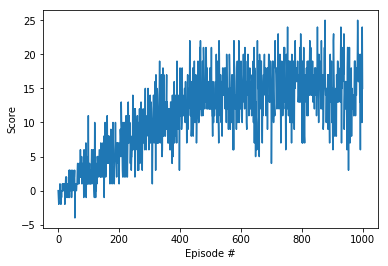

In [12]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
DISCOUNT_FACTOR = 0.99                # discount factor
TAU = 0.001              # for soft update of target parameters
LEARNING_RATE = 0.0005               # learning rate 
UPDATE_EVERY = 4        # how often to update the network
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Creating training agent
agent = DQN_Agent.create_agent(env)

#Training the agent and save scores
scores = train_agent(env, agent)

#Plotting the result of trained agent
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Creating agent :: brain BananaBrain, action size 4, state size 37
Begining inference with brain BananaBrain, number of games 10
Game 1 score 19.00 - average score 19.00
Game 2 score 15.00 - average score 17.00
Game 3 score 5.00 - average score 13.00
Game 4 score 17.00 - average score 14.00
Game 5 score 20.00 - average score 15.20
Game 6 score 15.00 - average score 15.17
Game 7 score 12.00 - average score 14.71
Game 8 score 18.00 - average score 15.12
Game 9 score 18.00 - average score 15.44
Game 10 score 21.00 - average score 16.00


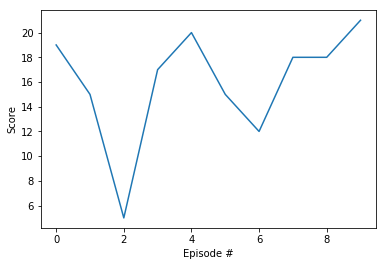

In [14]:
n_games = 10
max_t = 1000 

# create and init agent 
agent = DQN_Agent.create_agent(env, 'navigation_agent_checkpoint.pth')

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
    
print("Begining inference with brain {}, number of games {}".format(brain_name, n_games))

scores = [] # keep track of the scores 

for i_game in range(1, n_games+1):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]
    score = 0
        
    for t in range(max_t):                    
        # select action 
        action = int(agent.act(state)) 
        # send the action to the environment
        env_info = env.step(action)[brain_name]        
        # get next state 
        next_state = env_info.vector_observations[0]
        # get reward 
        reward = env_info.rewards[0]
        # see if episode has finished 
        done = env_info.local_done[0]                    
            
        # Increment score 
        score += reward
        # update current state with next state 
        state = next_state 
            
        # Exit if done 
        if done:
            break 

    scores.append(score) # save score                 
        
    print("Game {} score {:.2f} - average score {:.2f}".format(i_game, score, np.mean(scores)))
    
    
#Plotting the result of tested agent    
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()